# Schrodinger Equation - PINN Procedure

By Zeynep Sağlam, 2024

PINN stands for physics-based neural networks and is often used in scientific calculations, especially in solving differential equations. This procedure was developed as an alternative to traditional numerical analysis methods and is generally effective when data is sparse, noisy, or incomplete. In this notebook, the procedure required to create a Schrodinger equation PINN model will be explained. In this application, it was aimed to speed up the processing time by creating an artificial neural network that approximates the numerical solutions of the Schrödinger equation, one of the important equations of quantum mechanics.

### Steps to follow:
1) Importing Required Libraries
2) Dataset Creation (Optional)
3) Definition of Neural Network Architecture
4) Creation of Physics-Informed Loss Functions
5) Main Program &  Plotting Results

## 1) Importing Required Libraries and Defining the Necessary Functions

In [2]:
redo_all = False
redo_none = True

retrain_model = (True or redo_all) and not redo_none
wanna_save = (False or redo_all)
regenerate_data = (False or redo_all) and not redo_none
make_new_graphs = (False or redo_all) and not redo_none
save_to_drive = True and not redo_none

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import time
import tensorflow as tf
from func_timeout import func_timeout

2023-12-26 15:37:02.619732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 15:37:02.655413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 15:37:02.655437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 15:37:02.655457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 15:37:02.661322: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 15:37:02.661688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
m = 9.1094e-31 # Mass of an electron
hbar = 1.0546e-34 # Planck's constant over 2 * pi
e = 1.6022e-19 # charge of an electron
L = 5.2918e-11 # width of the well
v0 = 2.3e5 # potential different between 0 and well --> just for show

In [5]:
def integrate(arr, h):
    N = len(arr)
    
    sum_odd = sum(arr[1::2])
    sum_even = sum(arr[2:-1:2])
    
    result = (h / 3) * (arr[0] + arr[-1] + 4 * sum_odd + 2 * sum_even)
    
    return result

integrate([x**2 for x in np.arange(0, 5.1, 0.1)], 0.1) 


def normalize(psi_points):
        norm_factor = np.linalg.norm(psi_points)
        return psi_points / norm_factor

41.666666666666664

In [7]:
N=1000
h=L/N

x_points=np.arange(0, L, h)

def solve_schrodinger_equation(V,x_points,h):

    def solve(E):  
        #Function that obtains the wave function solution for a given energy E
        #using the fourth-order vector of the Runge-Kutta method.

        psi = 0.0
        phi = 1.0
        r = np.array([psi, phi], float)
        psi_points = []

        for x in x_points:
            psi_points.append(r[0])
            k1 = h * f(r, x, E)
            k2 = h * f(r + 0.5 * k1, x + 0.5 * h, E)
            k3 = h * f(r + 0.5 * k2, x + 0.5 * h, E)
            k4 = h * f(r + k3, x + h, E)
            r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

        return x_points, psi_points, r[0]
    
    def f(r, x, E):
        #The function that creates the vector function required for the application of the Runge-Kutta method.
        
        return np.array([r[1], 2*m / (hbar ** 2) * (V(x) - E) * r[0]])

    def find_energy_eigenvalue(E1, E2):
        #Function that uses the roots of the psi result at point L to find the ground state energy eigenvalues.
        
        psi2 = solve(E1)[2]
        epsilon = e / 1000

        while abs(E1 - E2) > epsilon:
            psi1, psi2 = psi2, solve(E2)[2]
            E1, E2 = E2, E2 - psi2 * (E2 - E1) / (psi2 - psi1)

        return E2

    def integrate(arr, h):
        N = len(arr)

        sum_odd = sum(arr[1::2])
        sum_even = sum(arr[2:-1:2])

        result = (h / 3) * (arr[0] + arr[-1] + 4 * sum_odd + 2 * sum_even)

        return result


    def normalize(psi_points):
        norm_factor = np.linalg.norm(psi_points)
        return psi_points / norm_factor

    E = find_energy_eigenvalue(0, e)

    x_points, psi_points, psi_final = solve(E)

    return x_points, normalize(psi_points), E

[0.0000000e+00 5.2918000e-14 1.0583600e-13 1.5875400e-13 2.1167200e-13
 2.6459000e-13 3.1750800e-13 3.7042600e-13 4.2334400e-13 4.7626200e-13
 5.2918000e-13 5.8209800e-13 6.3501600e-13 6.8793400e-13 7.4085200e-13
 7.9377000e-13 8.4668800e-13 8.9960600e-13 9.5252400e-13 1.0054420e-12
 1.0583600e-12 1.1112780e-12 1.1641960e-12 1.2171140e-12 1.2700320e-12
 1.3229500e-12 1.3758680e-12 1.4287860e-12 1.4817040e-12 1.5346220e-12
 1.5875400e-12 1.6404580e-12 1.6933760e-12 1.7462940e-12 1.7992120e-12
 1.8521300e-12 1.9050480e-12 1.9579660e-12 2.0108840e-12 2.0638020e-12
 2.1167200e-12 2.1696380e-12 2.2225560e-12 2.2754740e-12 2.3283920e-12
 2.3813100e-12 2.4342280e-12 2.4871460e-12 2.5400640e-12 2.5929820e-12
 2.6459000e-12 2.6988180e-12 2.7517360e-12 2.8046540e-12 2.8575720e-12
 2.9104900e-12 2.9634080e-12 3.0163260e-12 3.0692440e-12 3.1221620e-12
 3.1750800e-12 3.2279980e-12 3.2809160e-12 3.3338340e-12 3.3867520e-12
 3.4396700e-12 3.4925880e-12 3.5455060e-12 3.5984240e-12 3.6513420e-12
 3.704

Took 0.35103344917297363 seconds
E = 4.151055920032114e-16 J
Checking normalization: 1 = 5.29180000000004e-14


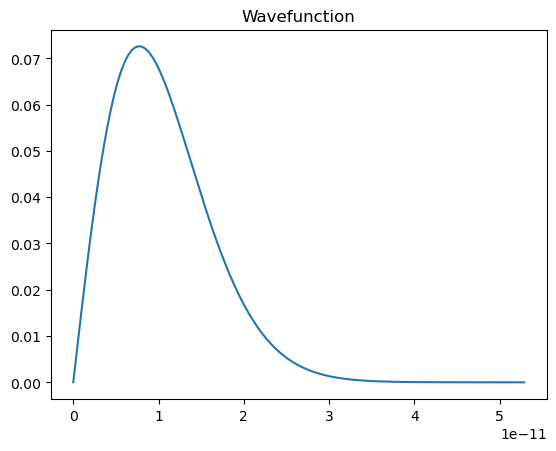

In [21]:
V = lambda x: x / L * 1e4 * e
cur_time = time.time()
x_points, psi_points, E = solve_schrodinger_equation(V,x_points,h)
print("Took", time.time() - cur_time, "seconds")
print("E =", E, "J")
print("Checking normalization: 1 =", integrate([psi ** 2 for psi in psi_points], L / len(psi_points)))

plt.title('Wavefunction')
plt.plot(x_points, psi_points)
plt.show()

## 2) Dataset Creation 

In [22]:
N = 100
h = L / N

x_points = np.arange(0, L, h)

np.random.seed(123)

def generate_sample(V):
    x_points, psi_points, E = solve_schrodinger_equation(V, N)
    inp = np.vectorize(V)(x_points) / e
    return inp, np.array([E / e] + psi_points)

inputs = []
outputs = []
file_name = 'dataset.npy'

if not regenerate_data:
    
    with open('dataset.npy', 'rb') as f:
        inputs, outputs = np.load(f)
    
else:

    print("Generating Dataset:")

    cur_time = time.time()

    num_of_points = 10000
    mod = num_of_points // 100

    for s in ['step', 'linear', 'fourier']:
        print('\r', s, 'potentials')
        for i in list(range(num_of_points // mod)) * mod:
            print("\rSize is", len(inputs), end='')
            def run():
                inp, target = generate_sample(generate_potential(s, i, p=int(np.random.random() * 6)))
                if np.nan not in inp and np.nan not in target:
                    inputs.append(inp)
                    outputs.append(target)
            try:
                func_timeout(60, run)
            except:
                print("\rData Point with Complexity", i, "timed out")

    print("\rDone - Took", to_readable_time(time.time() - cur_time), "seconds\n")


    print("Generated", len(inputs), "samples")

    inputs = np.array(inputs)
    outputs = np.array(outputs)

    with open(file_name, 'wb') as f:
        np.save(f, np.array([inputs, outputs]))

In [23]:
for x in range(len(inputs)):
    inp = inputs[x]
    if np.nan in inp or np.inf in inp:
        print("nan is in inputs")
    for i in inp:
        if i > 1e10:
            print("inputs[" + str(x) + "]")
            break

for x in range(len(outputs)):
    out = outputs[x]
    if np.nan in out or np.inf in out:
        print("nan is in outputs")
    for o in out:
        if o > 1e10:
            print("outputs[" + str(x) + "]", o)
            break

In [24]:
def preprocess(inputs, outputs):
    processed_inputs = []
    processed_outputs = []
    for inp, out in zip(inputs, outputs):
        norm_inp = inp - min(inp) if max(inp) == min(inp) else (inp - min(inp)) / (max(inp) - min(inp))
        fft_inp = np.fft.rfft(norm_inp)
        processed_inputs.append(np.concatenate((inp, norm_inp, np.real(fft_inp), np.imag(fft_inp), [min(inp), max(inp)])))
        processed_outputs.append([out[0] * 1e3] + list(out[1:]))
    return np.array(processed_inputs), np.array(processed_outputs)

## 3) Definition of Neural Network Architecture

In [25]:
print("Input Dim:", len(inputs[0]))

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='softplus', input_dim=len(inputs[0])),
    tf.keras.layers.Dense(512, activation='softplus'),
    tf.keras.layers.Dense(256, activation='softplus'),
    tf.keras.layers.Dense(len(outputs[0]), activation='linear')
])

model.compile(optimizer='adam',
              loss='mse')

model.summary()

epochs = 5

if retrain_model:
    history = model.fit(inputs, outputs, epochs=epochs)
    loss_history = history.history['loss']
    with open('loss_history.npy', 'wb') as f:
        np.save(f, np.array(loss_history))
else:
    model.load_weights('./model_weights.h5')
    with open('loss_history.npy', 'rb') as f:
        loss_history = np.load(f)

Input Dim: 100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 100)               25700     
                                                                 
Total params: 314468 (1.20 MB)
Trainable params: 314468 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4) Creation of Physics-Informed Loss Functions

In [26]:
retrain_epochs = 0
if retrain_epochs != 0:
    history = model.fit(inputs, outputs, epochs=retrain_epochs)
    loss_history = list(loss_history)
    loss_history += history.history['loss']
    with open('loss_history.npy', 'wb') as f:
        np.save(f, np.array(loss_history))

## 5) Main Program &  Plotting Results

Energy: 13202.0188800707
1/1 [==============================] - 0s 44ms/step
Predicted Energy: 0.012834247


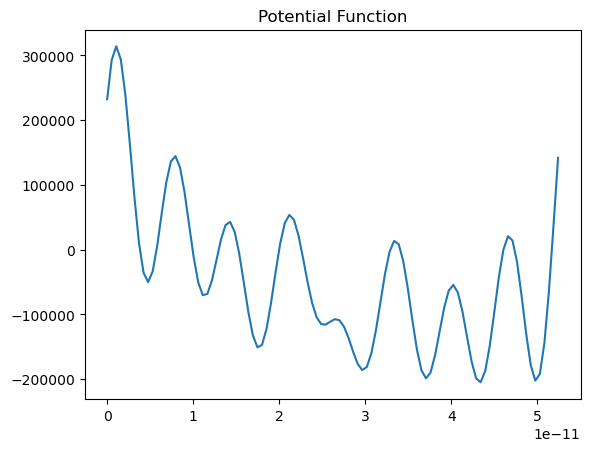

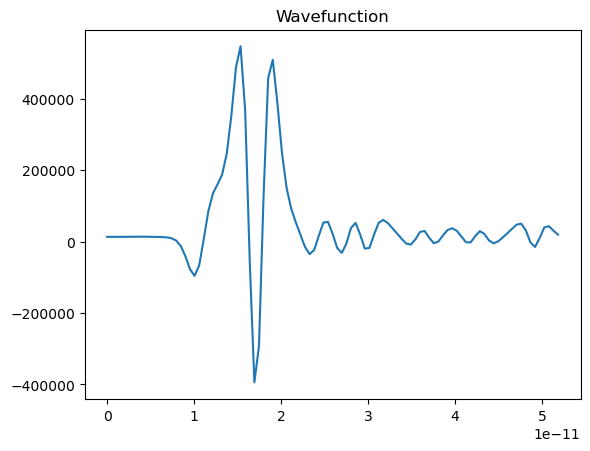

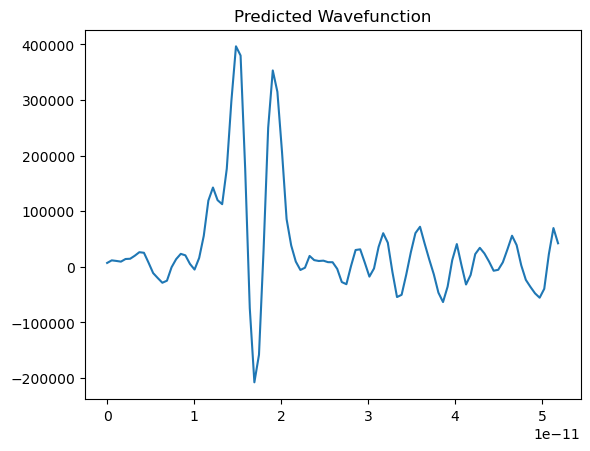

In [28]:
ind = 4000

print("Energy:", outputs[ind][0])
output = model.predict(np.array([inputs[ind]]))[0]

output = normalize(output)
print("Predicted Energy:", output[0])
plt.title("Potential Function")
plt.plot(x_points, inputs[ind][:len(x_points)])
plt.savefig("Potential Function.png".format(i),bbox_inches='tight')
plt.figure()
plt.title('Wavefunction')
plt.plot(x_points[:-1], outputs[ind][1:])
plt.savefig("Original.png".format(i),bbox_inches='tight')
plt.figure()
plt.title('Predicted Wavefunction')
plt.plot(x_points[:-1], output[1:]*10e5)
plt.savefig("Predicted.png".format(i),bbox_inches='tight')
plt.show()